<table width="50%"><tr>
<td> <img src="../../img/dipy_logo.png" align="left" alt="Drawing" style="width: 155px;"/> </td>
<td> <img src="../../img/gsoc_logo.png" align="right" alt="Drawing" style="width: 220px;"/> </td>
</tr></table>

# **Halfway Streamline Linear Registration: demo**

**Student**\
David Romero-Bascones\
**Mentors**\
Bramsh Qamar Chandio\
Shreyas Fadnavis\
Jong Sung Park

**Halfway streamline linear registration (HSLR):** is an alternative to streamline linear registration (SLR) by [Garyfallidis et al., 2015](https://www.sciencedirect.com/science/article/abs/pii/S1053811915003961?via%3Dihub). Concretely, instead of using one bundle as static, HSLR moves both bundles to a common space that lies in the middle to obtain a registration result that is unbiased towards any bundle.


**This demonstration:**
- Builds upon the SLR implementation availabe in DIPY
- Visualizes both SLR and HSLR for a pair of bundles

## **Preliminaries**

### Libraries and helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from dipy.viz import window, actor
from dipy.align.bundlemin import distance_matrix_mdf
from dipy.io.streamline import load_trk
from dipy.align.streamlinear import (StreamlineLinearRegistration,
                                     compose_matrix44, decompose_matrix44,
                                     remove_clusters_by_size)
from dipy.tracking.streamline import set_number_of_points, transform_streamlines, select_random_set_of_streamlines
from dipy.segment.clustering import qbx_and_merge

In [2]:
def bundle_distance_min(D):
    rows, cols = D.shape
    return 0.25 * (np.sum(np.min(D, axis=0)) / float(cols) +
                   np.sum(np.min(D, axis=1)) / float(rows)) ** 2


def show_bundles(bundles, linewidth=None, colors=None, opacity=None, show_3d=False, show_2d=False):

    n_bundle = len(bundles)
    if opacity is None:
        opacity = np.repeat(0.5, n_bundle)
    if linewidth is None:
        linewidth = np.repeat(0.3, n_bundle)
    scene = window.Scene()
    scene.SetBackground(1., 1, 1)
    for (i, bundle) in enumerate(bundles):
        lines_actor = actor.streamtube(
            bundle, linewidth=linewidth[i], opacity=opacity[i], colors=colors[i])
        lines_actor.RotateX(-90)
        lines_actor.RotateZ(90)
        scene.add(lines_actor)
    if show_3d:
        window.show(scene)
    if show_2d:
        # sleep(1)
        img = window.snapshot(scene, size=(600, 600))
        
        fig, ax = plt.subplots()
        fig.set_size_inches(8, 8)
        imgplot = ax.imshow(img)
        ax.invert_yaxis()
        ax.axis('off')
        plt.show()

### Load two bundles

In [3]:
# Data configuration
in_dir = '/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/PPMI_data'
bundle_name = 'AF_L'
sub1 = '3850'
sub2 = '3167'

file = f'{in_dir}/{sub1}/org_bundles/streamlines_moved_{bundle_name}__labels__recognized_orig.trk'
bundle_obj1 = load_trk(file, reference='same', bbox_valid_check=False)

file = f'{in_dir}/{sub2}/org_bundles/streamlines_moved_{bundle_name}__labels__recognized_orig.trk'
bundle_obj2 = load_trk(file, reference='same', bbox_valid_check=False)

# Define colors for later
col1 = [0.012, 0.329, 0.756]
col2 = [152/255, 0, 96/255]
col1m = [53/255, 170/255, 238/255]
col2m = [240/255, 150/255, 207/255]

### Preprocess bundles

In [4]:
np.random.seed(0)  # for reproducibility

# Adjust number of points
n_point = 20
bundle1 = set_number_of_points(bundle_obj1.streamlines, n_point)
bundle2 = set_number_of_points(bundle_obj2.streamlines, n_point)

# Limit the number of streamlines
n_stream = 1500
bundle1 = select_random_set_of_streamlines(bundle1, n_stream)
bundle2 = select_random_set_of_streamlines(bundle2, n_stream)

# Get centroids
qbx_th = 5
cluster1 = qbx_and_merge(bundle1, thresholds=[qbx_th])
centroids1 = remove_clusters_by_size(cluster1, 1)
cluster2 = qbx_and_merge(bundle2, thresholds=[qbx_th])
centroids2 = remove_clusters_by_size(cluster2, 1)

# Get initial BMD distance
d_0 = bundle_distance_min(distance_matrix_mdf(bundle1, bundle2))

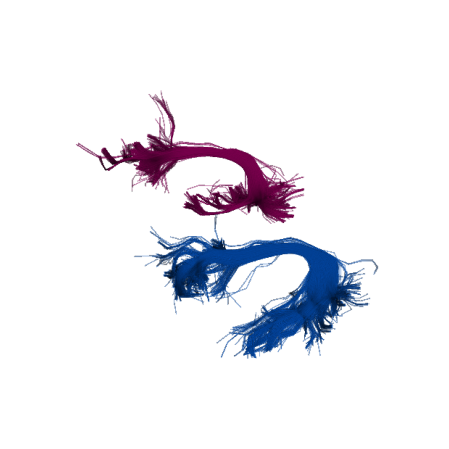

Distance in native space: 3003.7 mm


In [5]:
show_bundles([bundle1, bundle2], colors=[col1, col2], show_2d=True) # Use show_3d=True for fury rendering
print("Distance in native space: " + str(np.round(d_0,1)) + " mm")

## **SLR**

The result of SLR is a transformation matrix $\mathbf{T}_{12}$ mapping $\mathbf{x}$ coordinates in bundle1 space (moving) to bundle2 space $\mathbf{x}'$ (static):

$$\mathbf{x}' = \mathbf{T}_{12}\mathbf{x}$$

In [6]:
x0 = 'affine'
srr = StreamlineLinearRegistration(x0=x0)
srm = srr.optimize(static=centroids2, moving=centroids1)

# Get transformation matrix and parameters
T12 = srm.matrix
x12 = decompose_matrix44(T12)
trans, angles, scale, shear = x12[:3], x12[3:6], x12[6:9], x12[9:]

# Move bundle1 to bundle2 space and get distance
bundle12 = transform_streamlines(bundle1, T12)

# BMD distance after slr
d_slr = bundle_distance_min(distance_matrix_mdf(bundle2, bundle12))

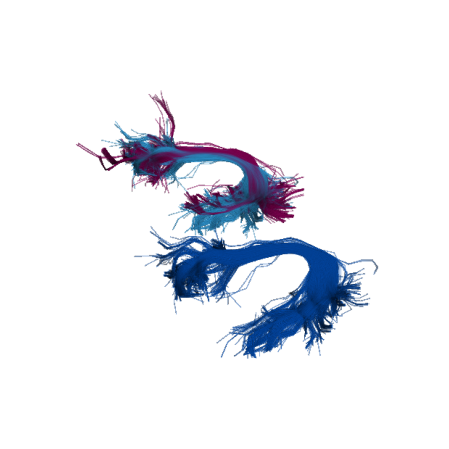

Distance after SLR: 19.8 mm


In [7]:
show_bundles([bundle1, bundle2, bundle12],colors=[col1, col2, col1m], show_2d=True)
print("Distance after SLR: " + str(np.round(d_slr,1)) + " mm")

## **HSLR**

The full SLR transformation $\mathbf{T}_{12}$ can be decomposed in two steps, one to the middle space $\mathbf{T}_{1m}$ and another $\mathbf{T}_{m2}$ from the middle to the second bundle space.

$$\mathbf{T}_{12}\mathbf{x} =\mathbf{T}_{m2}\mathbf{T}_{1m}\mathbf{x}$$

$$\mathbf{T}_{12} =\mathbf{T}_{m2}\mathbf{T}_{1m}$$

### **Step 1:** bundle1 to middle space

The transformation from bundle1 to the middle space is obtained by taking only half value of the estimated transformation parameters.

$$\mathbf{T}_{1m} =
\begin{cases}
\text{$t_{x}'=t_{x}/2$, $t_{y}'=t_{y}/2$, $t_{z}'=t_{z}/2$}\\
\text{$\theta_{x}'=\theta_{x}/2$, $\theta_{y}'=\theta_{y}/2$, $s_{z}'=\theta_{z}/2$}\\
\text{$s_{x}'=(1+s_{x})/2$, $s_{y}'=(1+s_{y})/2$, $s_{z}'=(1+s_{z})/2$}\\
\text{$sh_{x}'=sh_{x}/2$, $sh_{y}'=sh_{y}/2$, $sh_{z}'=sh_{z}/2$}
\end{cases}$$   


In [8]:
# Get transformation to  the middle space
x1m = np.concatenate((trans/2, angles/2, (1+scale)/2, shear/2))
T1m = compose_matrix44(x1m)

# Move bundle1 to the middle space
bundle1m = transform_streamlines(bundle1, T1m)
centroids1m = transform_streamlines(centroids1, T1m)

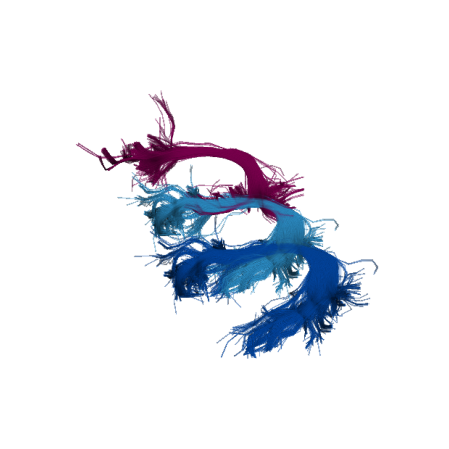

In [9]:
show_bundles([bundle1, bundle2, bundle1m],colors=[col1, col2, col1m], show_2d=True)

### **Step 2:** bundle2 to middle space

To now move bundle2 to the middle space we have several options available.

#### Option 1: analytical

We obtain $\mathbf{T}_{2m}$ analytically as:

$$\mathbf{T}_{12}\mathbf{T}_{1m}^{-1} =\mathbf{T}_{m2}\mathbf{T}_{1m}\mathbf{T}_{1m}^{-1}$$

$$ \mathbf{T}_{12}\mathbf{T}_{1m}^{-1} =\mathbf{T}_{m2}$$

$$\mathbf{T}_{2m} = \big(\mathbf{T}_{12}\mathbf{T}_{1m}^{-1}\big)^{-1}$$


In [10]:
# Compute T2m analytically
Tm2 = np.dot(T12, np.linalg.inv(T1m))
T2m_anal = np.linalg.inv(Tm2)


# Move bundle2 to the middle space
bundle2m_anal = transform_streamlines(bundle2, T2m_anal)

# BMD distance after hslr
d_hslr_anal = bundle_distance_min(distance_matrix_mdf(bundle1m, bundle2m_anal))

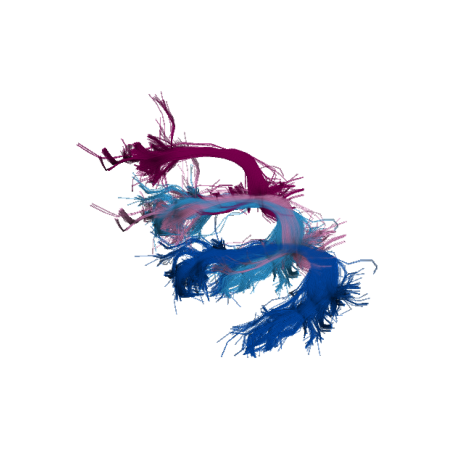

Distance after analytical HSLR: 27.1 mm


In [11]:
show_bundles([bundle1, bundle2, bundle1m, bundle2m_anal],colors=[col1, col2, col1m, col2m], show_2d=True)
print("Distance after analytical HSLR: " + str(np.round(d_hslr_anal,1)) + " mm")

#### Option 2: progressive (running SLR again)

We obtain $\mathbf{T}_{2m}$ by registering bundle2 to the bundle1 one already in the middle space (bundle1m). This involves running SLR twice.

In [12]:
# Run SLR again with middle space as static
srm = srr.optimize(static=centroids1m, moving=centroids2)
T2m_slr = srm.matrix

# Move bundle2 to the middle space
bundle2m_slr = transform_streamlines(bundle2, T2m_slr)

# BMD distance after hslr
d_hslr_slr = bundle_distance_min(distance_matrix_mdf(bundle1m, bundle2m_slr))

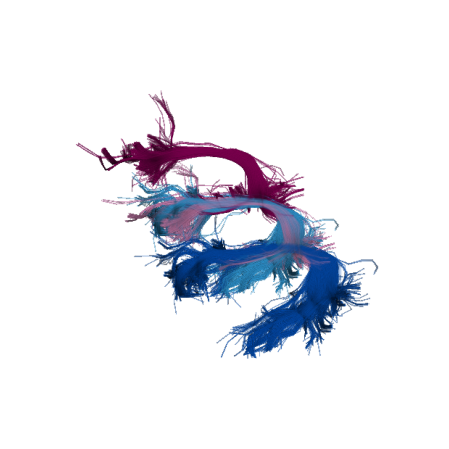

Distance after HSLR (2xSLR): 19.2 mm


In [13]:
show_bundles([bundle1, bundle2, bundle1m, bundle2m_slr],colors=[col1, col2, col1m, col2m], show_2d=True)
print("Distance after HSLR (2xSLR): " + str(np.round(d_hslr_slr,1)) + " mm")